In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import os
import sys
import time
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Activation, Dense, LeakyReLU
from tensorflow.keras.activations import relu, sigmoid, tanh  
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from keras.initializers import HeNormal
from tensorflow.keras.callbacks import Callback
from keras_tuner import BayesianOptimization

import AA_Import_LCP_Functions as chase_lcc
import AB_Import_Prep_XGB_Tune as chase_xgb_tune
import AC_Import_CG_AE_Test as chase_ae_cg_tune
import AD_Import_FG_AE_Tune as chase_ae_fg_tune

# Feature Importance Plot

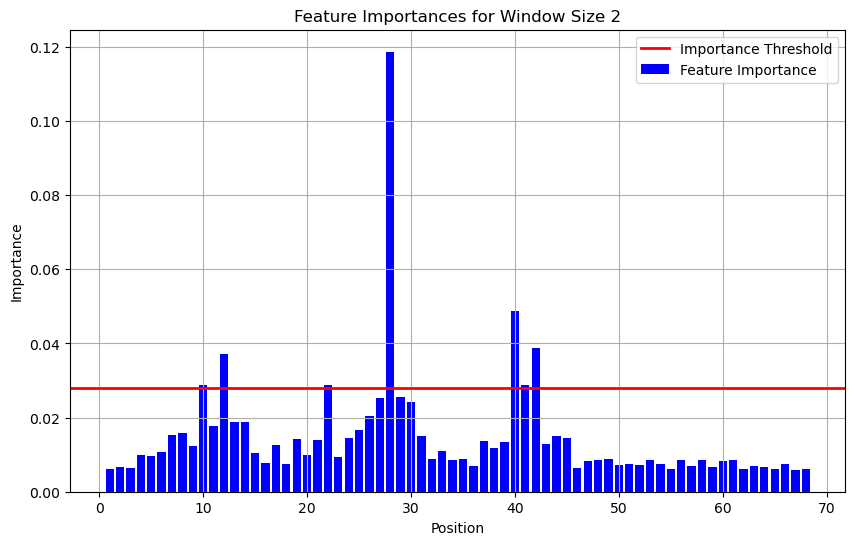

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Define the path to the CSV file
file_path = os.path.join('XGB_Position_Importance_Values_Trial_1', 'Feature_Importance_WS_2.csv')

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Plot the data
plt.figure(figsize=(10, 6))
plt.bar(df['Position'], df['Importance'], color='blue', label='Feature Importance')

# Add a red line at y=0.028
plt.axhline(y=0.028, color='red', linestyle='-', linewidth=2, label='Importance Threshold')

# Add labels and title
plt.xlabel('Position')
plt.ylabel('Importance')
plt.title('Feature Importances for Window Size 2')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


# Residue Coverage at Elbow

Elbow Threshold: 0.0278


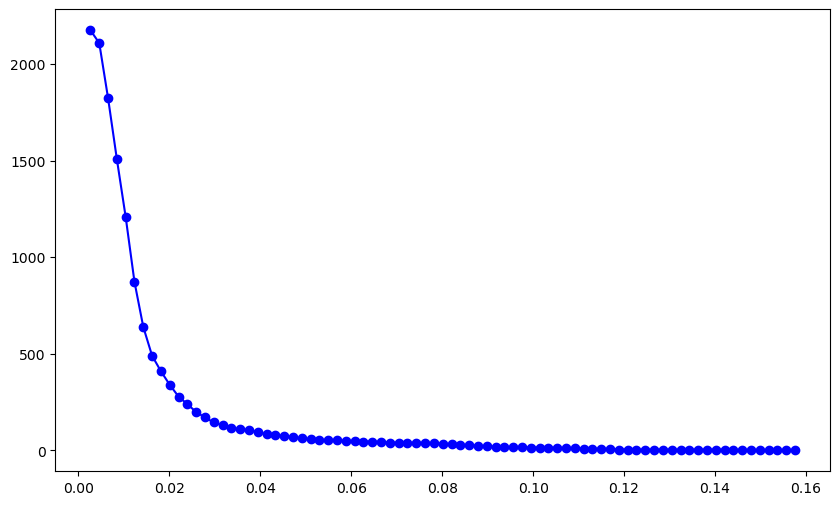

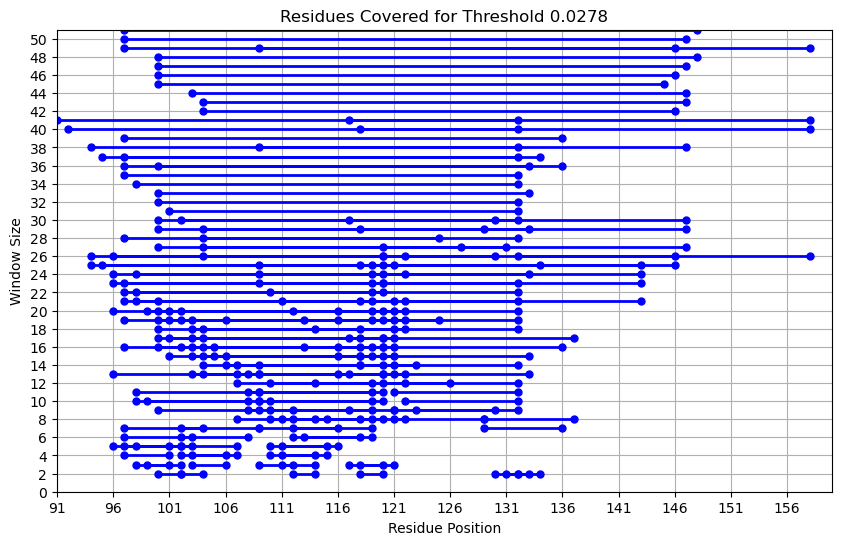

0.027816779814154396

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from kneed import KneeLocator

class Analysis:
    def __init__(self):
        self.window_sizes = range(2,52)
        self.elbow_thresholds = {}

    def run_analysis(self, trial_number):
        first_threshold, last_threshold, step_size = self.find_thresholds(trial_number)
        importance_thresholds = np.linspace(first_threshold, last_threshold, 81)[::1]
        elbow_threshold = self.calculate_and_plot_positions(importance_thresholds, trial_number)
        return elbow_threshold

    def find_thresholds(self, trial_number):
        max_adjusted_threshold = 0
        min_adjusted_threshold = float('inf')

        for window_size in self.window_sizes:
            df_importances = self.read_feature_importances(window_size, trial_number)
            if not df_importances.empty:
                df_importances['AdjustedImportance'] = df_importances['Importance'] * (70 - window_size) / 68
                max_importance = df_importances['AdjustedImportance'].max()
                min_importance = df_importances[df_importances['Importance'] > 0]['AdjustedImportance'].min()
                if max_importance > max_adjusted_threshold:
                    max_adjusted_threshold = max_importance
                if min_importance < min_adjusted_threshold:
                    min_adjusted_threshold = min_importance

        step_size = (max_adjusted_threshold - min_adjusted_threshold) / 80
        return max_adjusted_threshold, min_adjusted_threshold, step_size

    def read_feature_importances(self, window_size, trial_number):
        feature_importances_folder = f'XGB_Position_Importance_Values_Trial_{trial_number}'
        importance_file_path = os.path.join(feature_importances_folder, f'Feature_Importance_WS_{window_size}.csv')
        if os.path.exists(importance_file_path):
            return pd.read_csv(importance_file_path)
        else:
            print(f"No feature importances file found for window size {window_size}.")
            return pd.DataFrame({'Position': [], 'Importance': []})

    def calculate_and_plot_positions(self, importance_thresholds, trial_number):
        total_positions_by_threshold = {}
        previous_covered_positions = set()

        for threshold in importance_thresholds:
            current_covered_positions = set()
            plt.figure(figsize=(10, 6))

            for window_size in self.window_sizes:
                adjusted_threshold = self.calculate_adjusted_threshold(threshold, window_size)
                df_importances = self.read_feature_importances(window_size, trial_number)

                if not df_importances.empty:
                    important_features = df_importances[df_importances['Importance'] >= adjusted_threshold]['Position']

                    for feature in important_features:
                        start_residue = feature + 90
                        end_residue = start_residue + window_size
                        current_position_range = (start_residue, end_residue)
                        current_covered_positions.add(current_position_range)

                        plt.plot([start_residue, end_residue], [window_size, window_size], color='blue', marker='o', markersize=5, linewidth=2)

            previous_covered_positions.update(current_covered_positions)
            total_positions_by_threshold[threshold] = len(current_covered_positions)
            plt.close()

        thresholds = sorted(total_positions_by_threshold.keys())
        total_positions = [total_positions_by_threshold[threshold] for threshold in thresholds]

        plt.figure(figsize=(10, 6))
        plt.plot(thresholds, total_positions, '-o', color='blue')

        kneedle = KneeLocator(thresholds, total_positions, curve='convex', direction='decreasing', interp_method='polynomial')
        elbow_threshold = kneedle.elbow

        print(f"Elbow Threshold: {elbow_threshold:.4f}")

        for threshold in importance_thresholds:
            if threshold == elbow_threshold:
                current_covered_positions = set()
                plt.figure(figsize=(10, 6))

                for window_size in self.window_sizes:
                    adjusted_threshold = self.calculate_adjusted_threshold(threshold, window_size)
                    df_importances = self.read_feature_importances(window_size, trial_number)

                    if not df_importances.empty:
                        important_features = df_importances[df_importances['Importance'] >= adjusted_threshold]['Position']

                        for feature in important_features:
                            start_residue = feature + 90
                            end_residue = start_residue + window_size
                            current_position_range = (start_residue, end_residue)
                            current_covered_positions.add(current_position_range)

                            plt.plot([start_residue, end_residue], [window_size, window_size], color='blue', marker='o', markersize=5, linewidth=2)

                plt.title(f'Residues Covered for Threshold {threshold:.4f}')
                plt.xlabel('Residue Position')
                plt.ylabel('Window Size')
                plt.xlim(91, 160)
                plt.ylim(0, 51)
                plt.xticks(range(91, 161, 5))
                plt.yticks(range(0, 52, 2))
                plt.grid(True)
                plt.show()
                break

        return elbow_threshold

    def calculate_adjusted_threshold(self, importance_threshold, window_size):
        return importance_threshold * (68 / (70 - window_size))

# Example usage:
analysis = Analysis()
analysis.run_analysis(trial_number=1)
